<a href="https://colab.research.google.com/github/sarbaniAi/healthcare-kipu/blob/master/KIPU_Topic_Modeling_FORMSDATA_UNSUP_Clustering_3May.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## UPGRAD - Topic Modeling Articles with NMF

We will be using NMF model to cluster Customer Complaints into different groups.Extracting topics is a good unsupervised data-mining technique to discover the underlying relationships between texts.


*   List item
*   List item


*   DocumentAssembler
*   SentenceDetector
*   Tokenizer
*   NER (NER with GloVe 100D embeddings, CoNLL2003 dataset)
*   Lemmatizer
*   Stemmer
*   Part of Speech
*   SpellChecker (Norvig)

Other link - Text Classification in Spark NLP with Bert and Universal Sentence Encoders
Training a SOTA multi-class text classifier with Bert and Universal Sentence Encoders in Spark NLP with just a few lines of code in less than 10 min.

https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32


**Stages**
*   DocumentAssembler
*   SentenceDetector
*   Tokenizer
*   NER (NER with GloVe 100D embeddings, CoNLL2003 dataset)
*   Lemmatizer
*   Stemmer
*   Part of Speech
*   SpellChecker (Norvig)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file 
f = open('/content/drive/MyDrive/Colab Notebooks/dataset/kipu/data-prod.csv')
#complaints-2021-05-14_08_16.json') 
  
# returns JSON object as  
# a dictionary 
#data = json.load(f)
#df=pd.json_normalize(data)

In [ ]:
df_form = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/kipu/data-prod.csv")

In [ ]:
df_form.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14223 entries, 0 to 14222
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   form_id                 14223 non-null  int64  
 1   form_name               14223 non-null  object 
 2   id                      14223 non-null  int64  
 3   evaluation_id           14223 non-null  int64  
 4   name                    13818 non-null  object 
 5   field_type              14092 non-null  object 
 6   column_names            595 non-null    object 
 7   record_names            7730 non-null   object 
 8   show_string             1346 non-null   object 
 9   label                   12745 non-null  object 
 10  enabled                 14223 non-null  bool   
 11  created_at              14223 non-null  object 
 12  updated_at              14223 non-null  object 
 13  position                14198 non-null  float64
 14  css_style               11808 non-null

In [ ]:
df_form.shape

(14223, 34)

## Prepare the text for topic modeling

The dataset has 78313 customer complaints and 22 features. The customer complaint is in "_source.complaint_what_happened" column

We will rename the column names since they have changed due to normalization of JSON.

Remove rows with missing values in "complaint_what_happened" column

In [ ]:
df_form

,form_id,form_name,id,evaluation_id,name,field_type,column_names,record_names,show_string,label,...,image_width,image_height,item_group,label_width,default_value,pre_populate_with_id,optional,parent_item_id,conditions,skip_validations
0,227,Initial Treatment Plan (non-Detox),4476,227,Level of Treatment,radio_buttons,NaN,PHP|IOP|OP,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
1,227,Initial Treatment Plan (non-Detox),4477,227,Date Established,evaluation_datetime,NaN,NaN,NaN,Date Established,...,NaN,NaN,NaN,_20,NaN,NaN,False,NaN,NaN,False
2,774,Tx Hx Evaluation,18779,774,NaN,attachments,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
3,335,Nursing Assessment - Pain (duplicate),8069,335,"Does it ever go away, or is it constant? 2",radio_buttons,NaN,Always there|Comes and goes|N/A,NaN,"Does it ever go away, or is it constant?",...,NaN,NaN,NaN,_30,NaN,NaN,False,NaN,NaN,False
4,867,PTC Medical Progress Note,21525,867,Narrative,text,NaN,NaN,NaN,Assessment,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14218,1090,PTC - Biopsychosocial Assessment. Rev. 3,31263,1090,"X. E. Social, Cultural, Spiritual Environment",points_item,NaN,"'0 – Not at all'=>'0', '1 – Slightly'=>'1', '2...",NaN,"<li>Social, Cultural, Spiritual Environment</li>",...,NaN,NaN,loi,_50,NaN,NaN,False,NaN,NaN,False
14219,896,PTC - Biopsychosocial Assessment (LC),22475,896,II. RECOVERY ENVIRONMENT,title,NaN,NaN,NaN,<h1><center><u>II. RECOVERY ENVIRONMENT</u></c...,...,NaN,NaN,NaN,_100,NaN,NaN,False,NaN,NaN,False
14220,896,PTC - Biopsychosocial Assessment (LC),22493,896,II. A. 2. Partner:,check_box_first_value_none,NaN,None|Drugs|Alcohol|Mental Health|Criminal|Dece...,||||||true,<li>Partner:</li>,...,NaN,NaN,NaN,_20,NaN,NaN,False,NaN,NaN,False
14221,896,PTC - Biopsychosocial Assessment (LC),22461,896,I. A. Anticipated Discharge Date:,patient.anticipated_discharge_date,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False


In [ ]:
#print the column names
list(df_form.columns)

['form_id',
 'form_name',
 'id',
 'evaluation_id',
 'name',
 'field_type',
 'column_names',
 'record_names',
 'show_string',
 'label',
 'enabled',
 'created_at',
 'updated_at',
 'position',
 'css_style',
 'matrix_default_records',
 'show_string_css',
 'divider_below',
 'rule',
 'placeholder',
 'image_file_name',
 'image_content_type',
 'image_file_size',
 'image_updated_at',
 'image_width',
 'image_height',
 'item_group',
 'label_width',
 'default_value',
 'pre_populate_with_id',
 'optional',
 'parent_item_id',
 'conditions',
 'skip_validations']

In [ ]:
df_form["form_name"].value_counts().head(100)

PTC - Biopsychosocial Assessment VA OBOT/OP (LC), Rev. 3                 509
PTC - Biopsychosocial Assessment-VA OBOT/OP, Rev. 3                      509
PTC - Biopsychosocial Assessment - VA OBOT/OP (LC), Rev. 2               507
PTC - Biopsychosocial Assessment (LC), Rev. 2                            507
PTC - Biopsychosocial Assessment - VA OBOT/OP (N-LC), Rev. 2             507
                                                                        ... 
PTC - Nursing Assessment - Nutrition                                      31
PTC - Trauma Assessment                                                   31
PTC - ASAM - OP - Adult Level 1 - Discharge/Transfer Criteria (LC)        31
PTC - ASAM - IOP - Adult Level 2.1 - Discharge/Transfer Criteria (LC)     31
PTC - Release of Confidential Information - RWSS: Bellfonte Hospital      30
Name: form_name, Length: 100, dtype: int64

In [ ]:
df=df_form[['form_name','name','field_type']]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14223 entries, 0 to 14222
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   form_name   14223 non-null  object
 1   name        13818 non-null  object
 2   field_type  14092 non-null  object
dtypes: object(3)
memory usage: 333.5+ KB


In [ ]:
#Assigning new column names
#df.columns = ["index","type","id","score","tags","zip_code","complaint_id","issue","date_received","state","consumer_disputed","product","company_response","company","submitted_via","date_sent_to_company","company_public_response","sub_product","timely","complaint_what_happened","sub_issue","consumer_consent_provided"]

In [ ]:
#Assigning nan in place of blanks in the complaints column(complaint_what_happened)
df[df['name']==''] = np.nan
df[df['field_type']==''] = np.nan

In [ ]:
#Removing all rows where complaints column is nan
df=df.dropna(subset=['name'])

In [ ]:
df=df.dropna(subset=['field_type'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13722 entries, 0 to 14222
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   form_name   13722 non-null  object
 1   name        13722 non-null  object
 2   field_type  13722 non-null  object
dtypes: object(3)
memory usage: 428.8+ KB


## Prepare the text for topic modeling

There are 21072 rows after removing all the blank complaints.

Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers

Use POS tags to get relevant words from the texts. Using Nouns just 

Lemmatize the texts

In [ ]:
df

,form_name,name,field_type
0,Initial Treatment Plan (non-Detox),Level of Treatment,radio_buttons
1,Initial Treatment Plan (non-Detox),Date Established,evaluation_datetime
3,Nursing Assessment - Pain (duplicate),"Does it ever go away, or is it constant? 2",radio_buttons
4,PTC Medical Progress Note,Narrative,text
5,Initial Treatment Plan (non-Detox),Date Resolved,datestamp
...,...,...,...
14218,PTC - Biopsychosocial Assessment. Rev. 3,"X. E. Social, Cultural, Spiritual Environment",points_item
14219,PTC - Biopsychosocial Assessment (LC),II. RECOVERY ENVIRONMENT,title
14220,PTC - Biopsychosocial Assessment (LC),II. A. 2. Partner:,check_box_first_value_none
14221,PTC - Biopsychosocial Assessment (LC),I. A. Anticipated Discharge Date:,patient.anticipated_discharge_date


In [ ]:
df['name'].value_counts()

Amount of Use:      171
Age of First Use    170
Admit Date          148
Outcome             147
MSE                 122
                   ... 
5 2                   1
7 3                   1
5 1                   1
Discharge Type:       1
Pattern of Use:3      1
Name: name, Length: 2664, dtype: int64

In [ ]:
df['form_name'].value_counts()

PTC - Biopsychosocial Assessment VA OBOT/OP (LC), Rev. 3           486
PTC - Biopsychosocial Assessment-VA OBOT/OP, Rev. 3                486
PTC - Biopsychosocial Assessment - VA OBOT/OP (N-LC), Rev. 2       484
PTC - Biopsychosocial Assessment (LC), Rev. 2                      484
PTC - Biopsychosocial Assessment - VA OBOT/OP (LC), Rev. 2         484
                                                                  ... 
PTC - Patient Confidentiality                                        1
PTC - Confidentiality of Alcohol and Drug Abuse Patient Records      1
PTC - Consent to Treat                                               1
PTC - Notice of Privacy Practices                                    1
PTC - Code of Ethics                                                 1
Name: form_name, Length: 303, dtype: int64

In [ ]:
df['field_type'].value_counts()

title                               2420
check_box                           2380
text                                2145
radio_buttons                       1337
drop_down_list                      1258
                                    ... 
treatment_plan_problem                 2
patient.electronic_devices             2
care_team.Utilization_Management       2
patient.toggle_mars_generation         1
patient.recurring_forms                1
Name: field_type, Length: 62, dtype: int64

In [ ]:
import re, nltk, spacy, string
pd.options.mode.chained_assignment = None  
df.name=df.name.astype(str)
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_clean = pd.DataFrame(df.name.apply(lambda x: clean_text(x)))

In [ ]:
#Function to Lemmatize the texts
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [ ]:
#Creating a dataframe that will have only the text and the lemmatized text.
import en_core_web_sm
nlp = en_core_web_sm.load()
df_clean["name_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['name']), axis=1)

In [ ]:
df_clean

,name,name_lemmatize
0,level of treatment,level of treatment
1,date established,date establish
3,does it ever go away or is it constant,do -PRON- ever go away or be -PRON- constant
4,narrative,narrative
5,date resolved,date resolve
...,...,...
14218,x e social cultural spiritual environment,x e social cultural spiritual environment
14219,ii recovery environment,ii recovery environment
14220,ii a partner,ii a partner
14221,i a anticipated discharge date,i a anticipate discharge date


In [ ]:
'''One thing to notice is unlike verbs and common nouns, there's no clear base form of a personal pronoun. 
Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? 
spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.'''

'One thing to notice is unlike verbs and common nouns, there\'s no clear base form of a personal pronoun. \nShould the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? \nspaCy\'s solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.'

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
#Using custom Chunking
#Chunking in NLP is a process to take small pieces of information and group them into large units. The primary use of Chunking is making groups of "noun phrases.
#Here we are using only noun, singular as we have already lemmatized the texts.
import pandas as pd
from textblob import TextBlob

def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

def get_adjectives(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

df_clean["name_POS_removed"] =  df_clean.apply(lambda x: get_adjectives(x['name_lemmatize']), axis=1)

In [ ]:
#Now the clean dataframe .
df_clean

,name,name_lemmatize,name_POS_removed
0,level of treatment,level of treatment,level treatment
1,date established,date establish,date
3,does it ever go away or is it constant,do -PRON- ever go away or be -PRON- constant,
4,narrative,narrative,
5,date resolved,date resolve,date resolve
...,...,...,...
14218,x e social cultural spiritual environment,x e social cultural spiritual environment,e environment
14219,ii recovery environment,ii recovery environment,recovery environment
14220,ii a partner,ii a partner,partner
14221,i a anticipated discharge date,i a anticipate discharge date,anticipate discharge date


In [ ]:

import nltk.corpus
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

stop_words = stopwords.words('english')
df_clean['name_POS_removed'] = df_clean['name_POS_removed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

## Let’s do some quick exploratory data analysis to get familiar with the data.

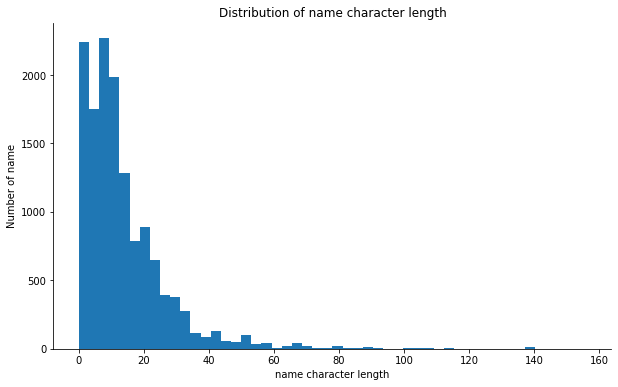

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.name_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.title('Distribution of name character length')
plt.ylabel('Number of name')
plt.xlabel('name character length')
sns.despine();

In [ ]:
#Removing the text whose length i less than 3

print(df_clean.shape)
df_clean = df_clean[df_clean['name_POS_removed'].apply(lambda x: len(str(x)) > 2)]
print(df_clean.shape)

(13722, 3)
(12159, 3)


In [ ]:
#doc_lens = [len(d) for d in df_clean.name_POS_removed]

df_clean.name_POS_removed

0                   level treatment
1                              date
5                      date resolve
6                  status discharge
7        pain typelocationbr x pain
                    ...            
14218                 e environment
14219          recovery environment
14220                       partner
14221     anticipate discharge date
14222               patient sibling
Name: name_POS_removed, Length: 12159, dtype: object

In [ ]:
doc_lens[4]

12

In [ ]:
df_clean

,name,name_lemmatize,name_POS_removed
0,level of treatment,level of treatment,level treatment
1,date established,date establish,date
5,date resolved,date resolve,date resolve
6,status at discharge,status at discharge,status discharge
7,here is the pain typelocationbr have patient p...,here be the pain typelocationbr have patient p...,pain typelocationbr x pain
...,...,...,...
14218,x e social cultural spiritual environment,x e social cultural spiritual environment,e environment
14219,ii recovery environment,ii recovery environment,recovery environment
14220,ii a partner,ii a partner,partner
14221,i a anticipated discharge date,i a anticipate discharge date,anticipate discharge date


## In terms of the distribution of the word counts, it’s skewed towards left. The maximum texts are short text.
## Here are the top 40 words by frequency among all the articles after processing the text.

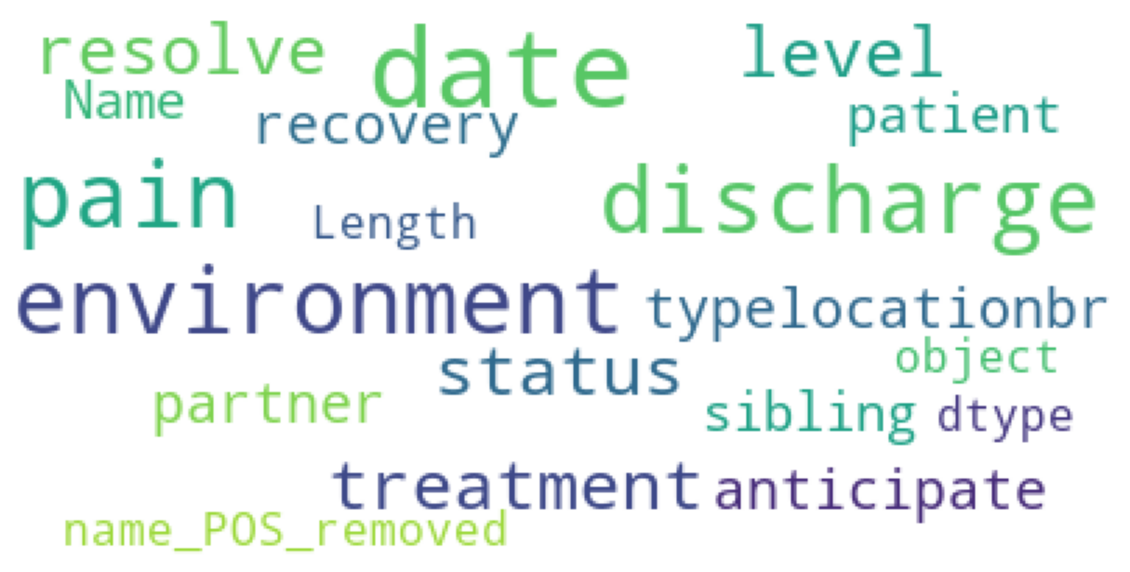

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(20.0,20.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=70,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['name_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
#Removing -PRON- from the text corpus
df_clean['name_clean'] = df_clean['name_POS_removed'].str.replace('-PRON-', '')

## Here are the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

Detect words which are some of the top words which makes sense given the focus of the complaints.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['name_clean'].values.astype('U'), 50)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 50 unigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [ ]:
df2.head(10)

,unigram,count
0,patient,1032
1,use,914
2,treatment,595
3,check,491
4,date,440
5,iii,390
6,box,354
7,assessment,311
8,ii,300
9,level,276


In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['name_clean'].values.astype('U'), 30)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 bigrams in the Complaint text after removing stop words and lemmatization"))
fig.show()

In [ ]:
df3.head(5)

,bigram,count
0,check box,328
1,episode facility,200
2,pattern use,178
3,age use,177
4,admit date,149


In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['name_clean'].values.astype('U'), 30)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 trigrams in the text"))
fig.show()

In [ ]:
df4.head(10)

,trigram,count
0,check roi file,65
1,modality start date,59
2,iii symptom withdrawal,52
3,symptom withdrawal check,51
4,withdrawal check box,51
5,patient health issue,49
6,need check box,46
7,author note check,40
8,note check roi,40
9,author note refer,32


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
#df_clean

## Lets now convert the raw texts to a matrix of TF-IDF features

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

min_df is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

## Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
dtm = tfidf.fit_transform(df_clean['name_clean'])

## NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In [ ]:
from sklearn.decomposition import NMF

## Coherence Model to select best number of Topics
With the Coherence Model we will see how to automatically select the best number of topics. 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary

In [ ]:
!python -m pip install -U gensim


In [ ]:
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [ ]:


# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['name_clean']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


## Manual Topic Modeling
With the CoherenceModel we got the best number of topics=5.The hard work is already done at this point so all we need to do is run the model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
nmf_model = NMF(n_components=5,random_state=40)

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

883

In [ ]:
#Print the top word of a sample component
single_topic = nmf_model.components_[0]
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

check
mount
inhalantslast
engage
length
box
substance
age
pattern
use


#Print Top15 words for each of the topics

In [ ]:
#Print Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['house', 'relate', 'needle', 'behavior', 'relapse', 'check', 'mount', 'inhalantslast', 'engage', 'length', 'box', 'substance', 'age', 'pattern', 'use']


THE TOP 15 WORDS FOR TOPIC #1
['need', 'history', 'vii', 'item', 'goal', 'ix', 'issue', 'health', 'level', 'ii', 'iii', 'box', 'check', 'treatment', 'patient']


THE TOP 15 WORDS FOR TOPIC #2
['startend', 'fall', 'attempt', 'treatmentservice', 'behavior', 'service', 'anticipate', 'discharge', 'time', 'admission', 'evaluation', 'start', 'modality', 'admit', 'date']


THE TOP 15 WORDS FOR TOPIC #3
['admission', 'level', 'loc', 'ptc', 'property', 'store', 'rule', 'clean', 'staff', 'rating', 'treatment', 'need', 'care', 'facility', 'episode']


THE TOP 15 WORDS FOR TOPIC #4
['discharge', 'soap', 'reason', 'summary', 'criterion', 'property', 'type', 'acceptance', 'time', 'care', 'condition', 'level', 'mse', 'transfer', 'mode']




In [ ]:
#Creating the best topic for each complaint
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([1, 2, 2, ..., 1, 2, 1])

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [ ]:
df_clean.head()

,name,name_lemmatize,name_POS_removed,name_clean,Topic
0,level of treatment,level of treatment,level treatment,level treatment,1
1,date established,date establish,date,date,2
5,date resolved,date resolve,date resolve,date resolve,2
6,status at discharge,status at discharge,status discharge,status discharge,1
7,here is the pain typelocationbr have patient p...,here be the pain typelocationbr have patient p...,pain typelocationbr x pain,pain typelocationbr x pain,1


In [ ]:
#Print the first 5 question for each of the Topics
df_dc=df_clean.groupby('Topic').head(5)
df_dc.sort_values('Topic')

,name,name_lemmatize,name_POS_removed,name_clean,Topic
36,attachment,attachment,attachment,attachment,0
43,attachment,attachment,attachment,attachment,0
40,attachment,attachment,attachment,attachment,0
33,attachment,attachment,attachment,attachment,0
24,age,age,age,age,0
9,insurance info,insurance info,insurance info,insurance info,1
0,level of treatment,level of treatment,level treatment,level treatment,1
7,here is the pain typelocationbr have patient p...,here be the pain typelocationbr have patient p...,pain typelocationbr x pain,pain typelocationbr x pain,1
6,status at discharge,status at discharge,status discharge,status discharge,1
8,pain chart image,pain chart image,pain chart image,pain chart image,1


In [ ]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:"Topic1",1:"Topic2", 2:"Others",3:"Topic3",4:"Topic4"}

In [ ]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,name,name_lemmatize,name_POS_removed,name_clean,Topic
0,level of treatment,level of treatment,level treatment,level treatment,Topic2
1,date established,date establish,date,date,Others
5,date resolved,date resolve,date resolve,date resolve,Others
6,status at discharge,status at discharge,status discharge,status discharge,Topic2
7,here is the pain typelocationbr have patient p...,here be the pain typelocationbr have patient p...,pain typelocationbr x pain,pain typelocationbr x pain,Topic2
...,...,...,...,...,...
14218,x e social cultural spiritual environment,x e social cultural spiritual environment,e environment,e environment,Topic2
14219,ii recovery environment,ii recovery environment,recovery environment,recovery environment,Topic2
14220,ii a partner,ii a partner,partner,partner,Topic2
14221,i a anticipated discharge date,i a anticipate discharge date,anticipate discharge date,anticipate discharge date,Others


## Supervised model to predict any new complaints to the relevant Topics.

We have seen how to get the topics of the complaints, now in the below section we will see how we can use them to classify any new complaints.

Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
Topic_names = {"Topic1":0,"Topic2":1,"Others":2,"Topic3":3,"Topic4":4}
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,name,name_lemmatize,name_POS_removed,name_clean,Topic
0,level of treatment,level of treatment,level treatment,level treatment,1
1,date established,date establish,date,date,2
5,date resolved,date resolve,date resolve,date resolve,2
6,status at discharge,status at discharge,status discharge,status discharge,1
7,here is the pain typelocationbr have patient p...,here be the pain typelocationbr have patient p...,pain typelocationbr x pain,pain typelocationbr x pain,1
...,...,...,...,...,...
14218,x e social cultural spiritual environment,x e social cultural spiritual environment,e environment,e environment,1
14219,ii recovery environment,ii recovery environment,recovery environment,recovery environment,1
14220,ii a partner,ii a partner,partner,partner,1
14221,i a anticipated discharge date,i a anticipate discharge date,anticipate discharge date,anticipate discharge date,2


In [ ]:
training_data=df_clean[["name","Topic"]]

In [ ]:
training_data

,name,Topic
0,level of treatment,1
1,date established,2
5,date resolved,2
6,status at discharge,1
7,here is the pain typelocationbr have patient p...,1
...,...,...
14218,x e social cultural spiritual environment,1
14219,ii recovery environment,1
14220,ii a partner,1
14221,i a anticipated discharge date,2


In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer


#GET VECTOR COUNT
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.name)

#SAVE WORD VECTOR
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

#TRANSFORM WORD VECTOR TO TF IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#SAVE TF-IDF
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))

In [ ]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = MultinomialNB().fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("nb_model.pkl", "wb"))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4", "Topic5"]

docs_new = "Have you ever been sexually abused?"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("nb_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

#for predicted_item, result in zip(predicted, y_test):
 #   print(target_names[predicted_item], ' - ', target_names[result])

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[ 505   58    1    3    0]
 [   7 1995    1    1    0]
 [   0   16  280    0    0]
 [   2   15    0   80    0]
 [   0    1    1    0   74]]
              precision    recall  f1-score   support

      Topic1       0.98      0.89      0.93       567
      Topic2       0.96      1.00      0.98      2004
      Topic3       0.99      0.95      0.97       296
      Topic4       0.95      0.82      0.88        97
      Topic5       1.00      0.97      0.99        76

    accuracy                           0.97      3040
   macro avg       0.98      0.93      0.95      3040
weighted avg       0.97      0.97      0.96      3040



In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("logreg_model.pkl", "wb"))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "Has any family member / significant other attempted to address / intervene in Clientâ€™s behavior and / or usage?"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("logreg_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic1  -  Topic1
Topic2  -  Topic2
Topic1  -  Topic1
Topic3  -  Topic3
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic5  -  Topic5
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  - 

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[ 520   47    0    0    0]
 [   1 2003    0    0    0]
 [   0   19  277    0    0]
 [   0   12    0   85    0]
 [   0    2    0    0   74]]
              precision    recall  f1-score   support

      Topic1       1.00      0.92      0.96       567
      Topic2       0.96      1.00      0.98      2004
      Topic3       1.00      0.94      0.97       296
      Topic4       1.00      0.88      0.93        97
      Topic5       1.00      0.97      0.99        76

    accuracy                           0.97      3040
   macro avg       0.99      0.94      0.96      3040
weighted avg       0.97      0.97      0.97      3040



In [ ]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("DT_model.pkl", "wb"))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "CLINICAL SUMMARY OF CLIENTâ€™S RESPONSE TO TREATMENT<br />(strengths/weaknesses, specific needs and concerns upon discharge)"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("DT_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic1  -  Topic1
Topic2  -  Topic2
Topic1  -  Topic1
Topic3  -  Topic3
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic5  -  Topic5
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic3  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  - 

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[ 524   43    0    0    0]
 [   6 1994    3    0    1]
 [   0   10  286    0    0]
 [   0    2    0   95    0]
 [   0    0    0    0   76]]
              precision    recall  f1-score   support

      Topic1       0.99      0.92      0.96       567
      Topic2       0.97      1.00      0.98      2004
      Topic3       0.99      0.97      0.98       296
      Topic4       1.00      0.98      0.99        97
      Topic5       0.99      1.00      0.99        76

    accuracy                           0.98      3040
   macro avg       0.99      0.97      0.98      3040
weighted avg       0.98      0.98      0.98      3040



In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

#SAVE MODEL
pickle.dump(clf, open("RF_model.pkl", "wb"))

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

docs_new = "Where do you live"
docs_new = [docs_new]

#LOAD MODEL
loaded_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
loaded_tfidf = pickle.load(open("tfidf.pkl","rb"))
loaded_model = pickle.load(open("RF_model.pkl","rb"))

X_new_counts = loaded_vec.transform(docs_new)
X_new_tfidf = loaded_tfidf.transform(X_new_counts)
predicted = loaded_model.predict(X_new_tfidf)

print(target_names[predicted[0]])

Topic2


In [ ]:
predicted = loaded_model.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    print(target_names[predicted_item], ' - ', target_names[result])

Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic3
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic5
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic3
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  -  Topic2
Topic1  -  Topic1
Topic2  -  Topic2
Topic2  -  Topic2
Topic2  - 

In [ ]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import f1_score

confusion_mat = confusion_matrix(y_test,predicted)
print(confusion_mat)
from sklearn.metrics import classification_report
target_names = ["Topic1","Topic2","Topic3","Topic4","Topic5"]

print(classification_report(y_test, predicted, target_names=target_names))

[[ 129  438    0    0    0]
 [   0 2004    0    0    0]
 [   0  296    0    0    0]
 [   0   49    0   48    0]
 [   0   76    0    0    0]]
              precision    recall  f1-score   support

      Topic1       1.00      0.23      0.37       567
      Topic2       0.70      1.00      0.82      2004
      Topic3       0.00      0.00      0.00       296
      Topic4       1.00      0.49      0.66        97
      Topic5       0.00      0.00      0.00        76

    accuracy                           0.72      3040
   macro avg       0.54      0.34      0.37      3040
weighted avg       0.68      0.72      0.63      3040



https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52

https://maxhalford.github.io/blog/unsupervised-text-classification/
